In [1]:
!pip install pyglyph
!pip install deap
!pip install graphviz
import neo_hook_model

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.10/bin/python3.10 -m pip install --upgrade pip' command.


In [20]:
from functools import partial

import deap.gp
import deap.tools
import numpy as np
import sympy
from sympy import *
from glyph import gp
from glyph.assessment import const_opt
from glyph.utils import Memoize
from glyph.utils.numeric import nrmse,rmse, silent_numpy
import random



pset = gp.numpy_primitive_set(arity=1,categories=("algebraic","symc"))
Individual = gp.Individual(pset=pset)
s_target = neo_hook_model.sigma(e = np.linspace(1,4,1000),mu = 1.49*10**9)
e = np.linspace(1,4,1000)

def error(ind, *args):
    f = gp.individual.numpy_phenotype(ind)
    y = s_target
    yhat = f(e, *args) 
    
    if np.isscalar(yhat):
        yhat = np.ones_like(y) * yhat
        
    return nrmse(y,yhat)

@Memoize
def measure(ind):
    popt, err_opr = const_opt(error, ind)
    ind.popt = popt
    return err_opr, len(ind)


def update_fitness(population, map=map):
    invalid = [p for p in population if not p.fitness.valid]
    fitnesses = map(measure, invalid)
    for ind, fit in zip(invalid, fitnesses):
        ind.fitness.values = fit
    return population

In [21]:
pop_size = 500

mate = deap.gp.cxOnePoint
expr_mut = partial(deap.gp.genFull, min_=1, max_=4)
mutate = partial(deap.gp.mutUniform, expr=expr_mut, pset=Individual.pset)
algorithm = gp.algorithms.AgeFitness(mate, mutate, deap.tools.selNSGA2, Individual.create_population)

pop = update_fitness(Individual.create_population(pop_size))
for gen in range(30):
    pop = algorithm.evolve(pop)
    pop = update_fitness(pop)
    best = deap.tools.selBest(pop, 1)[0]
    print(gp.individual.simplify_this(best), best.fitness.values)
    

-x_0*(Symc + x_0)*(2*Symc + zoo)*(Symc + x_0 - (Symc - x_0)*(Symc + x_0) + 1) (0.5010096700252937, 37.0)
zoo*(x_0**2 + 1)*(Symc*x_0 + Symc + x_0) (0.4969294695872947, 31.0)
-x_0*(x_0**2 + 1)*(Symc*x_0 + Symc + x_0)/(Symc*(Symc - 1)) (0.012644813492383973, 37.0)
-x_0*(x_0**2 + 1)*(Symc*x_0 + Symc + x_0)/(Symc*(Symc - 1)) (0.012644813492383973, 37.0)
-(Symc + x_0**3)*(Symc*x_0 + Symc + x_0)/(Symc*(Symc - 1)) (0.01253109375517365, 37.0)
-(Symc + x_0**3)*(Symc*x_0 + Symc + x_0)/(Symc*(Symc - 1)) (0.01253109375517365, 37.0)
-(x_0 + 1)*(Symc*x_0 + Symc + x_0)/(Symc - 1) (0.012441664525360253, 35.0)
-(Symc + 2*x_0)*(x_0 + 1)/(Symc - 1) (0.012090626426751258, 33.0)
-(Symc + 2*x_0)*(x_0 + 1)/(Symc - 1) (0.012090626426751258, 33.0)
-(Symc + 2*x_0)*(x_0 + 1)/(Symc - 1) (0.012090626426751258, 33.0)
-(Symc + 2*x_0)*(x_0 + 1)/(Symc - 1) (0.012090626426751258, 33.0)
-(Symc + 2*x_0)*(x_0 + 1)/(Symc - 1) (0.012090626426751258, 33.0)
-(Symc + x_0)*(2*Symc + x_0)/(Symc*(Symc - 1)) (0.00980697790276762, 3

In [22]:
from sympy import *
from sympy import sympify
import pickle

x, y, z, t = symbols('x y z t')
locals = {
  "Add": Add,
  "Mul": Mul,
  "Sub": Lambda((x, y), x - y),
  "Div": Lambda((x, y), x/y),
  "Sqrt":Lambda(x,sqrt(x)),
  "Exp": Lambda(x,exp(x)),
  "Neg": Lambda(x, -x),
  "log": Lambda(x,log(x))
}
#all_best = deap.tools.selBest(pop, 25)
#print(all_best)
sympify(str(gp.individual.simplify_this(best)),locals=locals)
#for element in all_best:
  #print(sympify(str(gp.individual.simplify_this(element)),locals=locals)) 
  #sympify(str(gp.individual.simplify_this(best)),locals=locals) #FINAL RESULT

(Symc**2*(Symc - 1) + (4*Symc + 4*x_0)*(2*Symc*(Symc - 1)*(Symc*x_0 + Symc + x_0) - x_0**3))/(Symc - 1)

In [23]:
from sympy import *
from sympy import sympify
import pickle
with open('best_mechanics_1_Layer_up_to_date_wo_exp.pkl', 'wb') as outp:
    pickle.dump(best, outp, pickle.HIGHEST_PROTOCOL)
popt,_=const_opt(error, best)
f = open("./results_best_mechanics_1_Layer_1.txt", "a")
f.write(f"best_mechanics_1_Layer_up_to_date_wo_exp\n\n{best}\n\n fitness and length : {best.fitness.values}\n - constant optimization : {popt} ")
f.close()

Text(0, 0.5, 's')

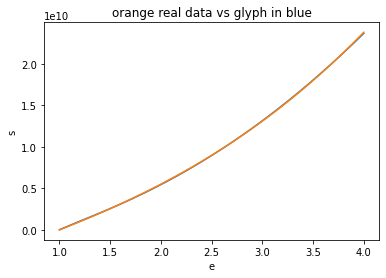

In [24]:

import pickle
import matplotlib.pyplot as plt
#

f = gp.individual.numpy_phenotype(best)

popt,_=const_opt(error, best) 
s_rs = f(e,*popt)

plt.title('orange real data vs glyph in blue')
plt.plot(e,s_target)
plt.plot(e,s_rs)
plt.xlabel('e')
plt.ylabel('s')